# Transformers for Multivariate Energy Price Forecasting - Seminar Paper
## Applied Predictive Analytics
## Humboldt University Berlin (SS24)
##
## Authors: Ekaterina Basova, Emircan Ince , Yash Chougule
## Supervisor: Georg Velev
##

### Agenda:
1. Data Loading & Preprocessing
2. Experimental Design
    - Benchmark Models
      - Linear Regression
      - LSTM
    - Pre trained Chronos
    - Transformers
      - Unification
      - Non-Stationary Autoformer
      - BasisFormer
      - iTransformer
      - Increased prediction length (96)
3. Results
4. Outlook
   - Chronos Simulation Framework
   - DYNOTEARS Causal Structure

# 1. Data Loading & Preprocessing

The first step is to load all the necessary libraries.

In [13]:
import os
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.weight_norm as wn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

import chronos
from chronos import ChronosPipeline

Calling the all_countries.csv file from the data folder.

In [16]:
##file_path = '/content/all_countries.csv' ## colab path
file_path = 'data/all_countries.csv' ## jupyter path
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
df.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Austria,AUT,2015-01-01 00:00:00,2015-01-01 01:00:00,17.93
1,Austria,AUT,2015-01-01 01:00:00,2015-01-01 02:00:00,15.17
2,Austria,AUT,2015-01-01 02:00:00,2015-01-01 03:00:00,16.38
3,Austria,AUT,2015-01-01 03:00:00,2015-01-01 04:00:00,17.38
4,Austria,AUT,2015-01-01 04:00:00,2015-01-01 05:00:00,16.38


The data is pivoted, setting the timestamp as the index and the country names as columns, with the corresponding electricity prices as values.

In [17]:
df = df [['Country','Datetime (UTC)',  'Price (EUR/MWhe)']]
df = df.pivot(index='Datetime (UTC)', columns='Country', values='Price (EUR/MWhe)')
df.head()

Country,Austria,Belgium,Bulgaria,Croatia,Czechia,Denmark,Estonia,Finland,France,Germany,...,Norway,Poland,Portugal,Romania,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland
Datetime (UTC),,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,17.93,34.94,NaN,NaN,24.20,18.29,23.37,23.37,34.94,17.93,...,27.36,17.18,48.10,44.17,NaN,24.20,23.25,48.10,23.37,43.43
2015-01-01 01:00:00,15.17,32.19,NaN,NaN,22.06,16.04,19.33,19.33,32.19,15.17,...,27.24,17.38,47.33,39.17,NaN,22.06,22.20,47.33,19.33,38.08
2015-01-01 02:00:00,16.38,28.05,NaN,NaN,20.27,14.60,17.66,17.66,23.53,16.38,...,27.16,17.40,42.27,26.93,NaN,20.27,19.56,42.27,17.66,35.47
2015-01-01 03:00:00,17.38,28.04,NaN,NaN,19.17,14.95,17.53,17.53,22.92,17.38,...,27.15,18.60,38.41,20.94,NaN,19.17,18.88,38.41,17.53,30.83
2015-01-01 04:00:00,16.38,34.26,NaN,NaN,17.90,14.50,18.07,18.07,34.26,16.38,...,27.30,19.30,35.72,18.52,NaN,17.90,18.39,35.72,18.07,28.26


In [ ]:
print(df.isnull().sum())

Country
Austria                0
Belgium                0
Bulgaria           15336
Croatia            24096
Czechia                0
Denmark                0
Estonia                0
Finland                0
France                 0
Germany                0
Greece                 0
Hungary                0
Ireland            12480
Italy                  0
Latvia                 0
Lithuania              0
Luxembourg             0
Netherlands            0
North Macedonia    73008
Norway                 0
Poland                 0
Portugal               0
Romania                0
Serbia             16800
Slovakia               0
Slovenia               0
Spain                  0
Sweden                 0
Switzerland            0
dtype: int64


Missing values are handled by dropping the samples that contained any NaNs to ensure a clean dataset.

In [18]:
df = df.dropna(axis=1)
print(df.isnull().sum())

Country
Austria        0
Belgium        0
Czechia        0
Denmark        0
Estonia        0
Finland        0
France         0
Germany        0
Greece         0
Hungary        0
Italy          0
Latvia         0
Lithuania      0
Luxembourg     0
Netherlands    0
Norway         0
Poland         0
Portugal       0
Romania        0
Slovakia       0
Slovenia       0
Spain          0
Sweden         0
Switzerland    0
dtype: int64


In [19]:
df.reset_index(inplace=True)
df.columns.name = None
print(df.head())

        Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  Finland  \
0  2015-01-01 00:00:00    17.93    34.94    24.20    18.29    23.37    23.37   
1  2015-01-01 01:00:00    15.17    32.19    22.06    16.04    19.33    19.33   
2  2015-01-01 02:00:00    16.38    28.05    20.27    14.60    17.66    17.66   
3  2015-01-01 03:00:00    17.38    28.04    19.17    14.95    17.53    17.53   
4  2015-01-01 04:00:00    16.38    34.26    17.90    14.50    18.07    18.07   

   France  Germany  Greece  ...  Netherlands  Norway  Poland  Portugal  \
0   34.94    17.93   48.78  ...        34.94   27.36   17.18     48.10   
1   32.19    15.17   31.10  ...        32.19   27.24   17.38     47.33   
2   23.53    16.38   20.78  ...        28.05   27.16   17.40     42.27   
3   22.92    17.38   25.40  ...        28.04   27.15   18.60     38.41   
4   34.26    16.38   26.00  ...        34.26   27.30   19.30     35.72   

   Romania  Slovakia  Slovenia  Spain  Sweden  Switzerland  
0    44.17   

In [20]:
df['Datetime (UTC)'] = pd.to_datetime(df['Datetime (UTC)'])
last_time_point = df['Datetime (UTC)'].max()
print("Last time point available:", last_time_point)

Last time point available: 2024-03-31 23:00:00


Selected only latest 2500 samples for training and testing.

In [21]:
# Find the latest timestamp in the DataFrame
latest_timestamp = df['Datetime (UTC)'].max()

# Calculate the timestamp for 2500 hours before the latest timestamp
start_timestamp = latest_timestamp - pd.Timedelta(hours=2500)

# Filter the DataFrame for the last 2500 hours
df = df[df['Datetime (UTC)'] >= start_timestamp]
print(df)

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
78571 2023-12-18 19:00:00    89.00    81.68    91.54    37.53    85.79   
78572 2023-12-18 20:00:00    84.92    79.97    76.34    33.87    76.89   
78573 2023-12-18 21:00:00    72.05    73.79    63.56    27.91    12.66   
78574 2023-12-18 22:00:00    59.58    68.67    53.21    31.94    10.08   
78575 2023-12-18 23:00:00    64.79    65.61    63.10    24.84    10.04   
...                   ...      ...      ...      ...      ...      ...   
81067 2024-03-31 19:00:00    66.17    47.01    68.37    70.00    50.09   
81068 2024-03-31 20:00:00    61.25    43.70    63.26    64.51    46.28   
81069 2024-03-31 21:00:00    44.99    50.29    51.29    54.90    43.98   
81070 2024-03-31 22:00:00    40.70    50.32    46.39    49.95    40.41   
81071 2024-03-31 23:00:00    32.10    44.39    42.60    48.98    40.39   

       Finland  France  Germany  Greece  ...  Netherlands  Norway  Poland  \
78571    17.20   82.07    77.98  1

Additional time-based features are extracted from the timestamp, including month, day, weekday, and hour, to provide temporal context for indexing expected by the model architecture.

In [22]:
df['month'] = df['Datetime (UTC)'].apply(lambda row: row.month)
df['day'] = df['Datetime (UTC)'].apply(lambda row: row.day)
df['weekday'] = df['Datetime (UTC)'].apply(lambda row: row.weekday())
df['hour'] = df['Datetime (UTC)'].apply(lambda row: row.hour)

print(df.head())

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
78571 2023-12-18 19:00:00    89.00    81.68    91.54    37.53    85.79   
78572 2023-12-18 20:00:00    84.92    79.97    76.34    33.87    76.89   
78573 2023-12-18 21:00:00    72.05    73.79    63.56    27.91    12.66   
78574 2023-12-18 22:00:00    59.58    68.67    53.21    31.94    10.08   
78575 2023-12-18 23:00:00    64.79    65.61    63.10    24.84    10.04   

       Finland  France  Germany  Greece  ...  Romania  Slovakia  Slovenia  \
78571    17.20   82.07    77.98  121.73  ...   121.73     79.23     97.78   
78572    15.21   77.93    71.09  101.76  ...   101.76    105.45     89.42   
78573    12.66   83.20    62.98  108.33  ...    93.64     66.12     79.61   
78574    10.08   79.46    55.12  102.52  ...    57.20     55.42     61.41   
78575     8.06   78.51    47.29   91.55  ...    72.64     55.56     69.50   

        Spain  Sweden  Switzerland  month  day  weekday  hour  
78571  174.00   17.20       

The data is split into training and testing sets using an 80-20 ratio. Separate splits are made for electricity prices and the newly created timestamp features.

In [23]:
# separating the electricity prices and timestamp features
electricity_prices_df = df[['Datetime (UTC)', 'Austria', 'Belgium', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
              'Germany', 'Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
             'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia',
             'Slovenia', 'Spain', 'Sweden', 'Switzerland']]
timestamp_features_df = df[['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']]

# defining the split ratio
train_size = 0.8
train_size_electricity = int(len(electricity_prices_df) * train_size)
train_size_timestamp = int(len(timestamp_features_df) * train_size)

# spliting the data into train and test sets
electricity_prices_train = electricity_prices_df[:train_size_electricity]
electricity_prices_test = electricity_prices_df[train_size_electricity:]
timestamp_features_train = timestamp_features_df[:train_size_timestamp]
timestamp_features_test = timestamp_features_df[train_size_timestamp:]

The electricity prices are normalized using StandardScaler, ensuring the model could train effectively without being affected by different ranges in the data.

In [ ]:
# rescaling the electricity prices
scaler = StandardScaler()

electricity_prices_train_scaled = scaler.fit_transform(electricity_prices_train.drop(columns=['Datetime (UTC)']))
electricity_prices_test_scaled = scaler.transform(electricity_prices_test.drop(columns=['Datetime (UTC)']))

Sequences are created for model input and output based on a given sequence length, label length and prediction horizon. The sequences are similar for 'basis_former', 'itransformer' and 'ns_autoformer' whereas changes slightly for 'chronos'. This is because since chronos is a pretrained model, it need not be trained, hence, no need of label length for validation. We only predict using chronos.

In [ ]:
def create_sequences(data, seq_length, pred_length, label_length, curr_model):
    seq_x = [] # storing for input seqiences
    seq_y = [] # storing for output seqiences
    for i in range(len(data) - seq_length - pred_length):
        seq_x.append(data[i:i+seq_length])
        if curr_model in ["basis_former", "itransformer", "ns_autoformer"]:
          seq_y.append(data[i+seq_length-label_length:i+seq_length+pred_length])
        else: ## only chronos
          seq_y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(seq_x), np.array(seq_y)

The sequences are converted into PyTorch tensors and wrapped into a DataLoader for efficient batching during model training. For the "basis_former" model, additional indexing was performed to normalize indices within the data.

In [ ]:
def create_dataloader(seq_x, seq_y, seq_x_mark, seq_y_mark, batch_size, curr_model):
    seq_x = torch.tensor(seq_x, dtype=torch.float32)
    seq_y = torch.tensor(seq_y, dtype=torch.float32)
    seq_x_mark = torch.tensor(seq_x_mark, dtype=torch.float32)
    seq_y_mark = torch.tensor(seq_y_mark, dtype=torch.float32)

    if curr_model == "basis_former":
        indices = []
        total_len = len(seq_x)
        for i in range(total_len):
            index_list = np.arange(i, i + len(seq_x[0]) + len(seq_y[0]), 1)
            norm_index = index_list / total_len
            indices.append(norm_index)
        indices = torch.tensor(indices, dtype=torch.float32)
        dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark, indices)
    else:
        dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark)

    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)
    return dataloader

# 2. Experimental Design

# Benchmark Models

To evaluate the performance of our advanced Transformer models in forecasting multivariate energy prices, we first establish baseline results using two benchmark models: Linear Regression and Long Short-Term Memory (LSTM) networks.
  
By comparing these benchmarks, we can better understand the strengths and weaknesses of the Transformer models in this specific forecasting task.

## Linear Regression

**Linear Regression** provides a simple, interpretable model that assumes linear relationships between the input features and the target variables. It serves as a baseline to compare against more complex models.


### Linear Model Preprocessing

In this step, we prepare the data for the Linear Regression model:

- **Lag Features**: We create lagged features to capture the relationship between the current and previous values of the target variable. This allows the model to consider temporal dependencies.
- **Data Splitting**: The dataset is split into training and testing sets, ensuring that we evaluate the model on unseen data.
- **Scaling**: Features and target variables are standardized to have a mean of 0 and a standard deviation of 1, but only after splitting the data to avoid information leakage.

This preprocessing ensures that the Linear Regression model can effectively learn from the data.

In [ ]:
# Copy the main dataframe for linear model preprocessing
df_linear = df.copy()

# Define the number of lagged features
lag_steps = 3

# List of all columns (already defined in the main preprocessing)
all_columns = df_linear.columns.tolist()

# List of columns to exclude (non-country columns)
exclude_columns = ['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']

# Define the country columns by excluding non-country columns
countries = [col for col in all_columns if col not in exclude_columns]

# Create lagged features for each country
for country in countries:
    for lag in range(1, lag_steps + 1):
        df_linear[f'{country}_lag_{lag}'] = df_linear[country].shift(lag)

# Drop rows with NaN values due to lagging
df_linear.dropna(inplace=True)

# Define features (X) and targets (Y)
X_numerical = df_linear.drop(columns=countries + ['Datetime (UTC)'])
Y = df_linear[countries]  # Target: current prices of all countries

# Split data into training and testing sets
train_size = 0.8
train_size_idx = int(len(X_numerical) * train_size)
X_train, X_test = X_numerical[:train_size_idx], X_numerical[train_size_idx:]
Y_train, Y_test = Y[:train_size_idx], Y[train_size_idx:]

# Standardize the features and targets using only the training data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

### Linear Regression Model

Here, we train and evaluate the Linear Regression model:

- **Training**: The model is trained on the preprocessed training data.
- **Prediction**: After training, the model makes predictions on the test set.
- **Evaluation**: We use Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to assess the model's performance, providing insight into its accuracy.

These metrics help us understand how well the Linear Regression model fits the data.

In [ ]:
# Initialize and train the linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, Y_train_scaled)

# Make predictions on the test set
Y_pred_lr = model_lr.predict(X_test_scaled)

# Inverse transform the predictions and the actual values back to the original scale
Y_pred_lr_original = scaler_Y.inverse_transform(Y_pred_lr)
Y_test_original = scaler_Y.inverse_transform(Y_test_scaled)

# Evaluate the model using MAE
mae_lr = mean_absolute_error(Y_test_original, Y_pred_lr_original)
print(f"Linear Regression Mean Absolute Error: {mae_lr}")

# Evaluate the model using RMSE
rmse_lr = np.sqrt(mean_squared_error(Y_test_original, Y_pred_lr_original))
print(f"Linear Regression Root Mean Squared Error: {rmse_lr}")

Linear Regression Mean Absolute Error: 7.121460465848673
Linear Regression Root Mean Squared Error: 12.298510526240198


## LSTM

**LSTM** is a more sophisticated neural network designed to capture temporal dependencies in sequential data. It is particularly useful for time series forecasting, allowing us to assess how well it handles the complexities in the dataset compared to the Transformer models.


### LSTM Preprocessing

In this section, we preprocess the data for the LSTM model:

- **Data Splitting**: The dataset is split into training and testing sets before any scaling is applied to avoid information leakage.
- **Scaling**: Both training and testing data are standardized using `StandardScaler` to ensure the LSTM model can effectively learn.
- **Sequence Creation**: We create sequences of a specified length to capture temporal dependencies, which are crucial for the LSTM model's learning process.

This preprocessing is tailored to the LSTM model's need to understand sequential data.

In [ ]:
# Copy the main dataframe for LSTM model preprocessing
df_lstm = df.copy()

# Split data into training and testing sets before scaling
train_size = int(len(df_lstm) * 0.8)
train_df = df_lstm.iloc[:train_size]
test_df = df_lstm.iloc[train_size:]

# Rescale the data using StandardScaler for LSTM
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']))
test_scaled = scaler.transform(test_df.drop(columns=['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']))

# Convert to a supervised learning problem by creating sequences
def create_sequences_lstm(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length (number of time steps)
seq_length = 96

# Create sequences
X_train, y_train = create_sequences_lstm(train_scaled, seq_length)
X_test, y_test = create_sequences_lstm(test_scaled, seq_length)

### LSTM Model

Here, we train and evaluate the LSTM model:

- **Model Architecture**: The LSTM model is built with two LSTM layers followed by a Dense layer, allowing it to capture complex temporal patterns.
- **Training**: The model is trained using the preprocessed data, with Early Stopping to prevent overfitting.
- **Evaluation**: After making predictions on the test set, we evaluate the model using MAE and RMSE, giving us a measure of its forecasting accuracy.

These steps ensure that the LSTM model is well-prepared to handle the complexities of time series data.

In [ ]:
# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=y_train.shape[1]))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with EarlyStopping
model_lstm.fit(X_train, y_train, epochs=50, batch_size=24,
               validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions
y_pred_lstm = model_lstm.predict(X_test)

# Inverse transform the scaled data to original values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred_lstm)

# Evaluate the model using MAE
mae_lstm = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"LSTM Mean Absolute Error: {mae_lstm}")

# Evaluate the model using RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
print(f"LSTM Root Mean Squared Error: {rmse_lstm}")

Epoch 1/50


2024-08-17 21:49:41.422320: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/RDC/inceemir/apa_group4_transformers_for_multivar_energy_forecasting/.venv/lib64/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.7113 - val_loss: 0.6439
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.4890 - val_loss: 0.4834
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.3603 - val_loss: 0.3544
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.2156 - val_loss: 0.2748
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.1786 - val_loss: 0.2429
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1493 - val_loss: 0.2280
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.1296 - val_loss: 0.2095
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1296 - val_loss: 0.2004
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0988 - val_loss: 0.1996
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.1044 - val_loss: 0.1966
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0977 - val_loss: 0.1892
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0993 - val_l

# Pretrained Chronos Framework

The first transformer-based model we tested was the Chronos. Published in March 2024, it is the most recent model used in this notebook. The authors use the small (46M parameters) and basic (200M parameters) pre-trained model variants.

As Chronos requires data in a different format from other transformer-based models, data pre-processing is performed first. The Chronos architecture treats time series as a simple sequence without considering temporal frequencies. This removes date features and performs a train & test split.

In [ ]:
seq_length = 96
pred_length = 48

## seleting countries because while testing not all countries were used, for the final version all are added
selected_countries = ['Austria', 'Belgium', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
              'Germany', 'Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
             'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia',
             'Slovenia', 'Spain', 'Sweden', 'Switzerland']

## extracting data for selected countries
data = df[selected_countries]

## train & test ratios
split_point = int(len(df) * 0.8)

## data split
train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]

### Small Version
A small version of the model with 46 million parameters is loaded from the Chronos package.

In [ ]:
## initializing Chronos pipeline (framework from original GitHub repo)
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

Chronos is designed to process univariate data. As the data for this analysis is multivariate, it is split by country and processed separately. In addition, the model accepts 1D tensors, so a function is written to create torch tensors for each country column.

In [ ]:
## function for creating tensors (format that chronos needs)
def prepare_chronos_data(data, seq_length):
    return torch.tensor(data[-seq_length:].values, dtype=torch.float32).unsqueeze(0)

### forecast loop for each country since Chronos can only process univariate data
results = {}

for country in selected_countries:
    ## printings for logging and checking if data is processed correctly
    print(f"\nProcessing {country}")
    print(f"Data range for {country}: {train_data[country].min()} to {train_data[country].max()}")
    ## tensors
    chronos_input = prepare_chronos_data(train_data[country], seq_length)
    print(f"Chronos input shape: {chronos_input.shape}")

    ## forecasting as showed in the repo
    forecast = pipeline.predict(
        context=chronos_input,
        prediction_length=pred_length,
        num_samples=20,
    )

    ## storing results
    results[country] = forecast
    print(f"Forecast shape: {forecast.shape}")


Processing Austria
Data range for Austria: -12.5 to 147.04
Chronos input shape: torch.Size([1, 96])
Forecast shape: torch.Size([1, 20, 48])

Processing Belgium
Data range for Belgium: -11.8 to 144.11
Chronos input shape: torch.Size([1, 96])
Forecast shape: torch.Size([1, 20, 48])

Processing Czechia
Data range for Czechia: -17.09 to 158.44
Chronos input shape: torch.Size([1, 96])
Forecast shape: torch.Size([1, 20, 48])

Processing Denmark
Data range for Denmark: -4.97 to 275.85
Chronos input shape: torch.Size([1, 96])
Forecast shape: torch.Size([1, 20, 48])

Processing Estonia
Data range for Estonia: -2.02 to 1896.0
Chronos input shape: torch.Size([1, 96])
Forecast shape: torch.Size([1, 20, 48])

Processing Finland
Data range for Finland: -2.5 to 1896.0
Chronos input shape: torch.Size([1, 96])
Forecast shape: torch.Size([1, 20, 48])

Processing France
Data range for France: -11.93 to 144.11
Chronos input shape: torch.Size([1, 96])
Forecast shape: torch.Size([1, 20, 48])

Processing Ge

The following evaluation metrics are now defined and calculated for each country.

In [ ]:
## evaluation metrics as in other transformers
def calculate_mse(actual, forecast):
    return np.mean((actual - forecast) ** 2)

def calculate_mae(actual, forecast):
    return np.mean(np.abs(actual - forecast))

def calculate_rmse(actual, forecast):
    return np.sqrt(calculate_mse(forecast, actual))

def calculate_mape(actual, forecast):
    return np.mean(np.abs((forecast - actual) / actual + 1e-5)) ## adding epsilon

mse_results = {}
mae_results = {}
mape_results = {}
rmse_results = {}

## evaluation for each country
for country in selected_countries:
    actual_values = test_data[country].values[:pred_length]
    ## since chronos produced 20 forecasts for each country, finding median within them
    forecasted_values = np.median(results[country], axis=1).flatten()
    ## matching test and forecast lenght to make sure  evaluation is consistent
    min_length = min(len(actual_values), len(forecasted_values))
    actual_values = actual_values[:min_length]
    forecasted_values = forecasted_values[:min_length]

    mse = calculate_mse(actual_values, forecasted_values)
    mae = calculate_mae(actual_values, forecasted_values)
    rmse = calculate_rmse(actual_values, forecasted_values)
    mape = calculate_mape(actual_values, forecasted_values)
    mse_results[country] = mse
    mae_results[country] = mae
    rmse_results[country] = rmse
    mape_results[country] = mape
    print(f"\nMSE for {country}: {mse}")
    print(f"MAE for {country}: {mae}")
    print(f"\nRMSE for {country}: {rmse}")
    print(f"MAPE for {country}: {mape}")


MSE for Austria: 1377.1959211825235
MAE for Austria: 33.97182075738907

RMSE for Austria: 37.11059041813433
MAPE for Austria: 0.42718874009340096

MSE for Belgium: 246.35925053619886
MAE for Belgium: 12.915189402898156

RMSE for Belgium: 15.69583545199805
MAPE for Belgium: 0.16125279587377492

MSE for Czechia: 1068.4946820076534
MAE for Czechia: 29.521004292170204

RMSE for Czechia: 32.68783691233872
MAPE for Czechia: 0.359955355545563

MSE for Denmark: 1726.6649134184088
MAE for Denmark: 34.86134136150281

RMSE for Denmark: 41.55315768288144
MAPE for Denmark: 0.4527950009699202

MSE for Estonia: 2144.8586789976985
MAE for Estonia: 41.87909220178922

RMSE for Estonia: 46.31261900387084
MAPE for Estonia: 0.5435857851755701

MSE for Finland: 709.5732684982034
MAE for Finland: 24.307278334299724

RMSE for Finland: 26.637816511459857
MAPE for Finland: 0.329354823164105

MSE for France: 164.02438319637128
MAE for France: 11.039518947601318

RMSE for France: 12.807200443358855
MAPE for Fran

/tmp/ipykernel_3526970/590783650.py:12: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((forecast - actual) / actual + 1e-5)) ## adding epsilon


To obtain an average performance for all univariate results, an average is calculated over them.

In [ ]:
## avg of the whole model
average_mse = np.mean(list(mse_results.values()))
print(f"\nAverage MSE across selected countries: {average_mse}")
average_mae = np.mean(list(mae_results.values()))
print(f"\nAverage MAE across selected countries: {average_mae}")
average_rmse = np.mean(list(rmse_results.values()))
print(f"\nAverage RMSE across selected countries: {average_rmse}")
average_mape = np.mean(list(mape_results.values()))
print(f"\nAverage MAPE across selected countries: {average_mape}")


Average MSE across selected countries: 1266.92876117344

Average MAE across selected countries: 28.146829042128683

Average RMSE across selected countries: 33.126424385571816

Average MAPE across selected countries: inf


### Base Version
Same procedure for base model version.

In [ ]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

results_2 = {}

for country in selected_countries:
    print(f"\nProcessing {country}")
    print(f"Data range for {country}: {train_data[country].min()} to {train_data[country].max()}")
    chronos_input = prepare_chronos_data(train_data[country], seq_length)
    print(f"Chronos input shape: {chronos_input.shape}")
    forecast_2 = pipeline.predict(
        context=chronos_input,
        prediction_length=pred_length,
        num_samples=20,
    )

    results_2[country] = forecast_2


Processing Austria
Data range for Austria: -12.5 to 147.04
Chronos input shape: torch.Size([1, 96])

Processing Belgium
Data range for Belgium: -11.8 to 144.11
Chronos input shape: torch.Size([1, 96])

Processing Czechia
Data range for Czechia: -17.09 to 158.44
Chronos input shape: torch.Size([1, 96])

Processing Denmark
Data range for Denmark: -4.97 to 275.85
Chronos input shape: torch.Size([1, 96])

Processing Estonia
Data range for Estonia: -2.02 to 1896.0
Chronos input shape: torch.Size([1, 96])

Processing Finland
Data range for Finland: -2.5 to 1896.0
Chronos input shape: torch.Size([1, 96])

Processing France
Data range for France: -11.93 to 144.11
Chronos input shape: torch.Size([1, 96])

Processing Germany
Data range for Germany: -13.37 to 150.09
Chronos input shape: torch.Size([1, 96])

Processing Greece
Data range for Greece: 0.04 to 190.96
Chronos input shape: torch.Size([1, 96])

Processing Hungary
Data range for Hungary: -13.01 to 183.11
Chronos input shape: torch.Size([

In [ ]:
mse_results_2 = {}
mae_results_2 = {}
mape_results_2 = {}
rmse_results_2 = {}

for country in selected_countries:
    actual_values = test_data[country].values[:pred_length]
    forecasted_values_2 = np.median(results_2[country], axis=1).flatten()
    min_length = min(len(actual_values), len(forecasted_values_2))
    actual_values = actual_values[:min_length]
    forecasted_values_2 = forecasted_values_2[:min_length]

    mse_2 = calculate_mse(actual_values, forecasted_values_2)
    mae_2 = calculate_mae(actual_values, forecasted_values_2)
    rmse_2 = calculate_rmse(actual_values, forecasted_values_2)
    mape_2 = calculate_mape(actual_values, forecasted_values_2)
    mse_results_2[country] = mse_2
    mae_results_2[country] = mae_2
    rmse_results_2[country] = rmse_2
    mape_results_2[country] = mape_2
    print(f"\nMSE for {country}: {mse_2}")
    print(f"MAE for {country}: {mae_2}")
    print(f"\nRMSE for {country}: {rmse_2}")
    print(f"MAPE for {country}: {mape_2}")


MSE for Austria: 773.4936684231992
MAE for Austria: 24.143480763435363

RMSE for Austria: 27.81175414142731
MAPE for Austria: 0.29619716157361714

MSE for Belgium: 127.9165796535528
MAE for Belgium: 8.577646487553915

RMSE for Belgium: 11.310021204823306
MAPE for Belgium: 0.11065585873889562

MSE for Czechia: 931.3943890948616
MAE for Czechia: 26.81776564598083

RMSE for Czechia: 30.518754710748954
MAPE for Czechia: 0.3293356203518319

MSE for Denmark: 1412.8281537525897
MAE for Denmark: 32.59973978678386

RMSE for Denmark: 37.58760638498533
MAPE for Denmark: 0.4155747502847836

MSE for Estonia: 1316.52801790989
MAE for Estonia: 32.845781043370565

RMSE for Estonia: 36.28399120700326
MAPE for Estonia: 0.4211230317205239

MSE for Finland: 334.5750945408876
MAE for Finland: 14.347600123087565

RMSE for Finland: 18.291394002122626
MAPE for Finland: 0.19601914184711577

MSE for France: 269.0242063930303
MAE for France: 13.661555274327597

RMSE for France: 16.40195739517178
MAPE for France

/tmp/ipykernel_3526970/590783650.py:12: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((forecast - actual) / actual + 1e-5)) ## adding epsilon


Results for base Chronos model.

In [ ]:
average_mse_2 = np.mean(list(mse_results_2.values()))
print(f"\nAverage MSE across selected countries: {average_mse_2}")
average_mae_2 = np.mean(list(mae_results_2.values()))
print(f"\nAverage MAE across selected countries: {average_mae_2}")
average_rmse_2 = np.mean(list(rmse_results_2.values()))
print(f"\nAverage RMSE across selected countries: {average_rmse_2}")
average_mape_2 = np.mean(list(mape_results_2.values()))
print(f"\nAverage MAPE across selected countries: {average_mape_2}")


Average MSE across selected countries: 959.6756625883841

Average MAE across selected countries: 24.1183179657672

Average RMSE across selected countries: 28.815673645797943

Average MAPE across selected countries: inf


# Transformers

## Unification

Given the train_loader and test_loader, the function 'fit' trains and/or tests the transformer model on that dataset.
1. **Model selection:** the argument 'model' loads the corresponding model and the associated configurations.
2. **Training and testing flags:** train_flag determins if the model must be trained, test_flag determines if the model must be tested. Also a pretrained model can be passed in which case only test_flag will be True.
3. **Arguments:** every model has its specific set of parameters in class 'Args' that define the configuration for training and testing.
4. **Return:** the function returns trained and/or tested model.

In [ ]:
def fit (model, train_flag, test_flag, train_loader=None, test_loader=None, pretrained_model=None):
    '''Fits a transformer model to the train and/or test loaders

    model - "basis_former", "itransformer", "ns_autoformer"

    train_flag: typ(bool) - True: to train the model on train_loader, False: if pretrained_model is passed

    test_flag: typ(bool) - True: to test on test_loader, False: if only training

    pretrained_model - pass a pretrained model if available to be fitted on a test_loader.
    eg. fit(basis_former, train_flag=False, test_flag=True, test_loader=test_loader, pretrained_model=model)
    '''

    if curr_model == 'basis_former':
        # Code for Basisforme

        import Basisformer.model
        importlib.reload(Basisformer.model)
        from Basisformer.model import Basisformer

        import Basisformer.main
        importlib.reload(Basisformer.main)
        from Basisformer.main import parse_args, model_setup, log_and_print
        importlib.reload(Basisformer.pyplot)

        class Args:
            is_training = True
            data_path = 'data'
            device = 0
            num_workers = 10
            features = 'M'
            freq = 'h'
            seq_len = 96
            pred_len = 48
            heads = 16
            d_model = 512
            N = 10
            block_nums = 2
            bottleneck = 2
            map_bottleneck = 20
            train_epochs = 50
            batch_size = 24
            learning_rate = 0.0001
            tau = 0.07
            loss_weight_prediction = 1.0
            loss_weight_infonce = 1.0
            loss_weight_smooth = 1.0
            check_point = 'checkpoint'
            patience = 3

        args = Args()

        # Set up device
        device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")

        # Set up model
        model = model_setup(args, device)

        if pretrained_model == None:
            # Set up model
            model = model_setup(args, device)

        else:
            model = pretrained_model


        if train_flag:
            import Basisformer.model
            importlib.reload(Basisformer.model)
            from Basisformer.model import Basisformer

            import Basisformer.main
            importlib.reload(Basisformer.main)
            from Basisformer.main import train


            record_dir = os.path.join('records', args.data_path.split('.')[0], 'features_' + args.features,
                                    'seq_len' + str(args.seq_len) + ',' + 'pred_len' + str(args.pred_len))

            if train_loader == None:
                return 'train_loader not found'

            # Call the train function
            train(model, train_loader, args, device, record_dir)

        else:
            if pretrained_model == None:
                return 'model not found which is required for testing'

        if test_flag :
            import Basisformer.main
            importlib.reload(Basisformer.main)
            from Basisformer.main import test

            if test_loader == None:
                return 'test_loader not found'

            test(model, test_loader, args, device, record_dir)
        return model


    elif curr_model == 'itransformer':
        # code for itransformer

        import iTransformer.experiment
        importlib.reload(iTransformer.experiment)
        from iTransformer.experiment import Exp_Long_Term_Forecast

        class Args:
            is_training = 1
            model_id = 'iTransformer_train'
            model = 'iTransformer'
            data = 'all_countries'
            features = 'M'
            target = 'OT'
            freq = 'h'
            checkpoints = './checkpoints/'
            seq_len = 96
            label_len = 48
            pred_len = 48
            enc_in = 24
            dec_in = 24
            c_out = 24
            d_model = 512
            n_heads = 8
            e_layers = 2
            d_layers = 1
            d_ff = 2048
            moving_avg = 25
            factor = 1
            distil = True
            dropout = 0.05
            embed = 'timeF'
            activation = 'gelu'
            output_attention = False
            do_predict = True
            num_workers = 10
            itr = 2
            train_epochs = 50
            batch_size = 24
            patience = 3
            learning_rate = 0.0001
            des = 'test'
            loss = 'mse'
            lradj = 'type1'
            use_amp = False
            use_gpu = True if torch.cuda.is_available() else False
            gpu = 0
            use_multi_gpu = False
            devices = '0,1,2,3'
            exp_name = 'MTSF'
            channel_independence = False
            inverse = False
            class_strategy = 'projection'
            target_root_path = './data'
            target_data_path = 'all_countries'
            efficient_training = False
            use_norm = True
            partial_start_index = 0
            seed = 2021
            p_hidden_dims = [128, 128]
            p_hidden_layers = 2

        args = Args()

        if pretrained_model == None:
            # Initialize the experiment
            exp = Exp_Long_Term_Forecast(args)

        else:
            return 'pretrained not valid for iTransformer and ns_autoformer'

        # Define the settings
        setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
            args.model_id, args.model, args.data, args.features, args.seq_len, args.label_len,
            args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
            args.factor, args.embed, args.distil, args.des, 0)

        if train_flag:
            Exp_Long_Term_Forecast.train(self=exp, train_loader=train_loader, setting=setting)

        if test_flag:
            Exp_Long_Term_Forecast.test(self=exp, test_loader=test_loader, setting=setting, test=0)
        return exp.model

    elif curr_model == 'ns_autoformer':
        # code for itransformer

        import ns_Autoformer.ns_Autoformer
        importlib.reload(ns_Autoformer.ns_Autoformer)
        from ns_Autoformer.ns_Autoformer import Model

        from ns_Autoformer.main import Exp_Main

        class Args:
            is_training = 1
            model_id = 'ns_autoformer_train'
            model = 'ns_Autoformer'
            features = 'M'
            target = 'OT'
            freq = 'h'
            checkpoints = './checkpoints/'
            seq_len = 96
            label_len = 48
            pred_len = 48
            enc_in = 24
            dec_in = 24
            c_out = 24
            d_model = 512
            n_heads = 8
            e_layers = 2
            d_layers = 1
            d_ff = 2048
            moving_avg = 25
            factor = 1
            distil = True
            dropout = 0.05
            embed = 'timeF'
            activation = 'gelu'
            output_attention = False
            do_predict = True
            num_workers = 10
            itr = 2
            train_epochs = 50
            batch_size = 24
            patience = 3
            learning_rate = 0.0001
            des = 'test'
            loss = 'mse'
            lradj = 'type1'
            use_amp = False
            use_gpu = True if torch.cuda.is_available() else False
            gpu = 0
            use_multi_gpu = False
            devices = '0,1,2,3'
            seed = 2021
            p_hidden_dims = [128, 128]
            p_hidden_layers = 2

        args = Args()

        if pretrained_model == None:
            # Initialize the experiment
            exp = Exp_Main(args)

        # Define the setting string
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
            args.model_id, args.model, args.features, args.seq_len, args.label_len,
            args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
            args.factor, args.embed, args.distil, args.des, 0)

        if train_flag:
            Exp_Main.train(self=exp, train_loader=train_loader, setting=setting)

        if test_flag:
            Exp_Main.test(self=exp, test_loader=test_loader, setting=setting, test=0)
        return exp.model

## Nonstationary Autoformer

The Nonstationary Autoformer is a specialized Transformer model designed to handle nonstationary time series data effectively. This section outlines the preparation and training process of the Nonstationary Autoformer model.

### Data Preparation

We first prepare the data sequences required for training and testing the Nonstationary Autoformer model:

- **Sequence Creation**: We generate sequences for both the electricity prices and corresponding timestamp features for the training and testing datasets.
- **PyTorch DataLoader**: These sequences are then converted into PyTorch `DataLoader` objects, which will be fed into the model for training and evaluation.

This preparation step ensures that the model receives data in the correct format for learning and prediction.

In [ ]:
seq_length = 96
pred_length = 48
label_length = 48
batch_size = 24

In [ ]:
curr_model = "ns_autoformer"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

### Model Training and Evaluation

The model is trained and tested using the prepared `DataLoader` objects:

- **Training and Testing**: The `fit` function is called with the model type, training flag, and testing flag set to `True`. This function trains the model on the training data and then evaluates its performance on the test data.

By training and testing the Nonstationary Autoformer, we can assess its ability to forecast multivariate energy prices under nonstationary conditions.

In [ ]:
ns_autoformer_train_test_48_pred = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

Use GPU: cuda:0
Epoch: 1 cost time: 9.170212507247925
Epoch: 1, Steps: 77 | Train Loss: 1.3706557
Validation loss decreased (inf --> 1.370656).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 7.460994720458984
Epoch: 2, Steps: 77 | Train Loss: 0.7722959
Validation loss decreased (1.370656 --> 0.772296).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 7.602068185806274
Epoch: 3, Steps: 77 | Train Loss: 0.6973021
Validation loss decreased (0.772296 --> 0.697302).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 7.4225404262542725
Epoch: 4, Steps: 77 | Train Loss: 0.6553520
Validation loss decreased (0.697302 --> 0.655352).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5 cost time: 7.446813344955444
Epoch: 5, Steps: 77 | Train Loss: 0.6268754
Validation loss decreased (0.655352 --> 0.626875).  Saving model ...
Updating learning rate to 6.25e-06
Epoch: 6 cost time: 7.51957368850708
Epoch: 6, Steps: 77 | Train

## Basisformer


### Data Preparation

In [ ]:
curr_model = "basis_former"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)

train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

### Model Training and Evaluation

In [ ]:
basisformer_train_test_48_pred = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
	iters: 15, epoch: 1 | loss: 3.2205608
	iters: 30, epoch: 1 | loss: 1.8433468


## iTransformer

iTransformer in its architecture applies attention and feed-forward network on the inverted dimsenions. Inverted means creating the tokens along the variates, instead of creating along the timestamp. By inverting, the embedded token aggregates the global representations of series that can be more
variate-centric and better leveraged by applying attention mechanisms for multivariate correlating.

### Data Preparation

train_loader and test_loader are created and then passed to the fit function to train and test using itransformer.

In [ ]:
curr_model = "itransformer"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

### Model Training and Evaluation

In [ ]:
itransformer_train_test_48_pred = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

Use GPU: cuda:0


Epoch: 1 cost time: 1.582637071609497
Epoch: 1, Steps: 77 | Train Loss: 0.6365194
Validation loss decreased (inf --> 0.636519).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 1.6112422943115234
Epoch: 2, Steps: 77 | Train Loss: 0.5127320
Validation loss decreased (0.636519 --> 0.512732).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 1.5666236877441406
Epoch: 3, Steps: 77 | Train Loss: 0.4534520
Validation loss decreased (0.512732 --> 0.453452).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 1.5693845748901367
Epoch: 4, Steps: 77 | Train Loss: 0.4236801
Validation loss decreased (0.453452 --> 0.423680).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5 cost time: 1.5648770332336426
Epoch: 5, Steps: 77 | Train Loss: 0.4066485
Validation loss decreased (0.423680 --> 0.406649).  Saving model ...
Updating learning rate to 6.25e-06
Epoch: 6 cost time: 1.598283290863037
Epoch: 6, Steps: 77 | Train Loss: 0.397

## Increasing prediction length
In order to get more comprehensive results transformer models are going to be tested

In [ ]:
def fit (model, train_flag, test_flag, train_loader=None, test_loader=None, pretrained_model=None):
    '''Fits a transformer model to the train and/or test loaders

    model - "basis_former", "itransformer", "ns_autoformer"

    train_flag: typ(bool) - True: to train the model on train_loader, False: if pretrained_model is passed

    test_flag: typ(bool) - True: to test on test_loader, False: if only training

    pretrained_model - pass a pretrained model if available to be fitted on a test_loader.
    eg. fit(basis_former, train_flag=False, test_flag=True, test_loader=test_loader, pretrained_model=model)
    '''

    if curr_model == 'basis_former':
        # Code for Basisforme

        import Basisformer.model
        importlib.reload(Basisformer.model)
        from Basisformer.model import Basisformer

        import Basisformer.main
        importlib.reload(Basisformer.main)
        from Basisformer.main import parse_args, model_setup, log_and_print
        importlib.reload(Basisformer.pyplot)

        class Args:
            is_training = True
            data_path = 'data'
            device = 0
            num_workers = 10
            features = 'M'
            freq = 'h'
            seq_len = 96
            pred_len = 96
            heads = 16
            d_model = 512
            N = 10
            block_nums = 2
            bottleneck = 2
            map_bottleneck = 20
            train_epochs = 50
            batch_size = 24
            learning_rate = 0.0001
            tau = 0.07
            loss_weight_prediction = 1.0
            loss_weight_infonce = 1.0
            loss_weight_smooth = 1.0
            check_point = 'checkpoint'
            patience = 3

        args = Args()

        # Set up device
        device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")

        # Set up model
        model = model_setup(args, device)

        if pretrained_model == None:
            # Set up model
            model = model_setup(args, device)

        else:
            model = pretrained_model


        if train_flag:
            import Basisformer.model
            importlib.reload(Basisformer.model)
            from Basisformer.model import Basisformer

            import Basisformer.main
            importlib.reload(Basisformer.main)
            from Basisformer.main import train


            record_dir = os.path.join('records', args.data_path.split('.')[0], 'features_' + args.features,
                                    'seq_len' + str(args.seq_len) + ',' + 'pred_len' + str(args.pred_len))

            if train_loader == None:
                return 'train_loader not found'

            # Call the train function
            train(model, train_loader, args, device, record_dir)

        else:
            if pretrained_model == None:
                return 'model not found which is required for testing'

        if test_flag :
            import Basisformer.main
            importlib.reload(Basisformer.main)
            from Basisformer.main import test

            if test_loader == None:
                return 'test_loader not found'

            test(model, test_loader, args, device, record_dir)
        return model


    elif curr_model == 'itransformer':
        # code for itransformer

        import iTransformer.experiment
        importlib.reload(iTransformer.experiment)
        from iTransformer.experiment import Exp_Long_Term_Forecast

        class Args:
            is_training = 1
            model_id = 'iTransformer_train'
            model = 'iTransformer'
            data = 'all_countries'
            features = 'M'
            target = 'OT'
            freq = 'h'
            checkpoints = './checkpoints/'
            seq_len = 96
            label_len = 48
            pred_len = 96
            enc_in = 24
            dec_in = 24
            c_out = 24
            d_model = 512
            n_heads = 8
            e_layers = 2
            d_layers = 1
            d_ff = 2048
            moving_avg = 25
            factor = 1
            distil = True
            dropout = 0.05
            embed = 'timeF'
            activation = 'gelu'
            output_attention = False
            do_predict = True
            num_workers = 10
            itr = 2
            train_epochs = 50
            batch_size = 24
            patience = 3
            learning_rate = 0.0001
            des = 'test'
            loss = 'mse'
            lradj = 'type1'
            use_amp = False
            use_gpu = True if torch.cuda.is_available() else False
            gpu = 0
            use_multi_gpu = False
            devices = '0,1,2,3'
            exp_name = 'MTSF'
            channel_independence = False
            inverse = False
            class_strategy = 'projection'
            target_root_path = './data'
            target_data_path = 'all_countries'
            efficient_training = False
            use_norm = True
            partial_start_index = 0
            seed = 2021
            p_hidden_dims = [128, 128]
            p_hidden_layers = 2

        args = Args()

        if pretrained_model == None:
            # Initialize the experiment
            exp = Exp_Long_Term_Forecast(args)

        else:
            return 'pretrained not valid for iTransformer and ns_autoformer'

        # Define the settings
        setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
            args.model_id, args.model, args.data, args.features, args.seq_len, args.label_len,
            args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
            args.factor, args.embed, args.distil, args.des, 0)

        if train_flag:
            Exp_Long_Term_Forecast.train(self=exp, train_loader=train_loader, setting=setting)

        if test_flag:
            Exp_Long_Term_Forecast.test(self=exp, test_loader=test_loader, setting=setting, test=0)
        return exp.model

    elif curr_model == 'ns_autoformer':
        # code for itransformer
        import ns_Autoformer.ns_Autoformer
        importlib.reload(ns_Autoformer.ns_Autoformer)
        from ns_Autoformer.ns_Autoformer import Model

        from ns_Autoformer.main import Exp_Main

        class Args:
            is_training = 1
            model_id = 'ns_autoformer_train'
            model = 'ns_Autoformer'
            features = 'M'
            target = 'OT'
            freq = 'h'
            checkpoints = './checkpoints/'
            seq_len = 96
            label_len = 48
            pred_len = 96
            enc_in = 24
            dec_in = 24
            c_out = 24
            d_model = 512
            n_heads = 8
            e_layers = 2
            d_layers = 1
            d_ff = 2048
            moving_avg = 25
            factor = 1
            distil = True
            dropout = 0.05
            embed = 'timeF'
            activation = 'gelu'
            output_attention = False
            do_predict = True
            num_workers = 10
            itr = 2
            train_epochs = 50
            batch_size = 24
            patience = 3
            learning_rate = 0.0001
            des = 'test'
            loss = 'mse'
            lradj = 'type1'
            use_amp = False
            use_gpu = True if torch.cuda.is_available() else False
            gpu = 0
            use_multi_gpu = False
            devices = '0,1,2,3'
            seed = 2021
            p_hidden_dims = [128, 128]
            p_hidden_layers = 2

        args = Args()

        if pretrained_model == None:
            # Initialize the experiment
            exp = Exp_Main(args)

        # Define the setting string
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
            args.model_id, args.model, args.features, args.seq_len, args.label_len,
            args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
            args.factor, args.embed, args.distil, args.des, 0)

        if train_flag:
            Exp_Main.train(self=exp, train_loader=train_loader, setting=setting)

        if test_flag:
            Exp_Main.test(self=exp, test_loader=test_loader, setting=setting, test=0)
        return exp.model

In [ ]:
seq_length = 96
pred_length = 96 ## new
label_length = 48

In [ ]:
curr_model = "ns_autoformer"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)

test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)

train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

ns_autoformer_train_test_96_pred = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

Use GPU: cuda:0
Epoch: 1 cost time: 8.146090269088745
Epoch: 1, Steps: 75 | Train Loss: 1.3117549
Validation loss decreased (inf --> 1.311755).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 8.107336282730103
Epoch: 2, Steps: 75 | Train Loss: 0.8179602
Validation loss decreased (1.311755 --> 0.817960).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 8.109177589416504
Epoch: 3, Steps: 75 | Train Loss: 0.7076564
Validation loss decreased (0.817960 --> 0.707656).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 8.145787954330444
Epoch: 4, Steps: 75 | Train Loss: 0.6070210
Validation loss decreased (0.707656 --> 0.607021).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5 cost time: 8.135039329528809
Epoch: 5, Steps: 75 | Train Loss: 0.5709493
Validation loss decreased (0.607021 --> 0.570949).  Saving model ...
Updating learning rate to 6.25e-06
Epoch: 6 cost time: 8.174699544906616
Epoch: 6, Steps: 75 | Train

In [ ]:
curr_model = "basis_former"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

basisformer_train_test_96_pred = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
	iters: 15, epoch: 1 | loss: 3.5914116
	iters: 30, epoch: 1 | loss: 2.3875632


In [ ]:
curr_model = "itransformer"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)

test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)

train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

itransformer_train_test_96_pred = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

Use GPU: cuda:0
Epoch: 1 cost time: 1.5678038597106934
Epoch: 1, Steps: 75 | Train Loss: 0.7505169
Validation loss decreased (inf --> 0.750517).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 1.531540870666504
Epoch: 2, Steps: 75 | Train Loss: 0.6204305
Validation loss decreased (0.750517 --> 0.620431).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 1.5764129161834717
Epoch: 3, Steps: 75 | Train Loss: 0.5608784
Validation loss decreased (0.620431 --> 0.560878).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 1.5272290706634521
Epoch: 4, Steps: 75 | Train Loss: 0.5285256
Validation loss decreased (0.560878 --> 0.528526).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5 cost time: 1.5751512050628662
Epoch: 5, Steps: 75 | Train Loss: 0.5143290
Validation loss decreased (0.528526 --> 0.514329).  Saving model ...
Updating learning rate to 6.25e-06
Epoch: 6 cost time: 1.5692532062530518
Epoch: 6, Steps: 75 | 

# 3. Results - Models Performance Comparison

In this section, we compare the performance of different models based on their Root Mean Squared Error (RMSE) values.

The table below summarizes the RMSE and MAE values obtained from each model, providing a comparison of their performance.

In [ ]:
# Create a dictionary to hold the results
results = {
    'Model': ['Linear Regression', 'LSTM',
              'Chronos small', 'Chronos base',
              'Ns_Autoformer (pred_length= 48)',
              'Ns_Autoformer (pred_length= 96)',
              'Basisformer (pred_length= 48)',
              'Basisformer (pred_length= 96)',
              'iTransformer (pred_length= 48)',
             'iTransformer (pred_length= 96)'],
    'RMSE': [12.29, 15.60, 33.12, 28.81, 0.77, 0.99, 0.89, 0.88, 0.75, 0.78],
    'MAE': [7.12, 9.70, 28.14, 24.11, 0.58, 0.74, 0.64, 0.65, 0.54, 0.57]
}

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame(results)

# Display the results table
print(results_df)

                             Model   RMSE    MAE
0                Linear Regression  12.29   7.12
1                             LSTM  15.60   9.70
2                    Chronos small  33.12  28.14
3                     Chronos base  28.81  24.11
4  Ns_Autoformer (pred_length= 48)   0.77   0.58
5  Ns_Autoformer (pred_length= 96)   0.99   0.74
6    Basisformer (pred_length= 48)   0.89   0.64
7    Basisformer (pred_length= 96)   0.88   0.65
8   iTransformer (pred_length= 48)   0.75   0.54
9   iTransformer (pred_length= 96)   0.78   0.57


# 4. Outlook

In [3]:
## inserting these libraries here because by loading them local can crush
import pyarrow.ipc as ipc
import networkx as nx
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.structure.notears import from_pandas

## Chronos Simulation

Kernel Synth is part of the Chronos pre-training with synthetic data. It uses Gaussian processes to simulate data distributions.

In [8]:
!python supporting_files_chronos/kernel-synth.py --num-series 500 --max-kernels 2

100% 500/500 [01:49<00:00,  4.56it/s]


In [11]:
file_path = 'supporting_files_chronos/kernelsynth-data.arrow'

with open(file_path, 'rb') as f:
    reader = ipc.RecordBatchFileReader(f)
    table = reader.read_all()

df_ch = table.to_pandas()

print(df_ch)

         start target._np_shape  \
0   2000-01-01        [1024, 3]   
1   2000-01-01        [1024, 3]   
2   2000-01-01        [1024, 3]   
3   2000-01-01        [1024, 3]   
4   2000-01-01        [1024, 3]   
..         ...              ...   
495 2000-01-01        [1024, 3]   
496 2000-01-01        [1024, 3]   
497 2000-01-01        [1024, 3]   
498 2000-01-01        [1024, 3]   
499 2000-01-01        [1024, 3]   

                                                target  
0    [-1.3293273404902177e-07, 1.7617705479648852e-...  
1    [0.8820515850319665, -2.630758929416405, -0.28...  
2    [1.0917233174006584, -0.30767090449730106, 0.1...  
3    [-1.4419568333102197, -0.2799756872675115, -0....  
4    [-0.8402086553986396, -1.5435372346614247, -0....  
..                                                 ...  
495  [5.2983733022775885, -9.044641569560579, -3.15...  
496  [-0.7313010836303305, -0.8540684084420854, 0.9...  
497  [-0.8684795217377739, -0.5001586491794001, 0.2...  
498  [0.8

To better see the results, plots of the first 15 simulations are created.

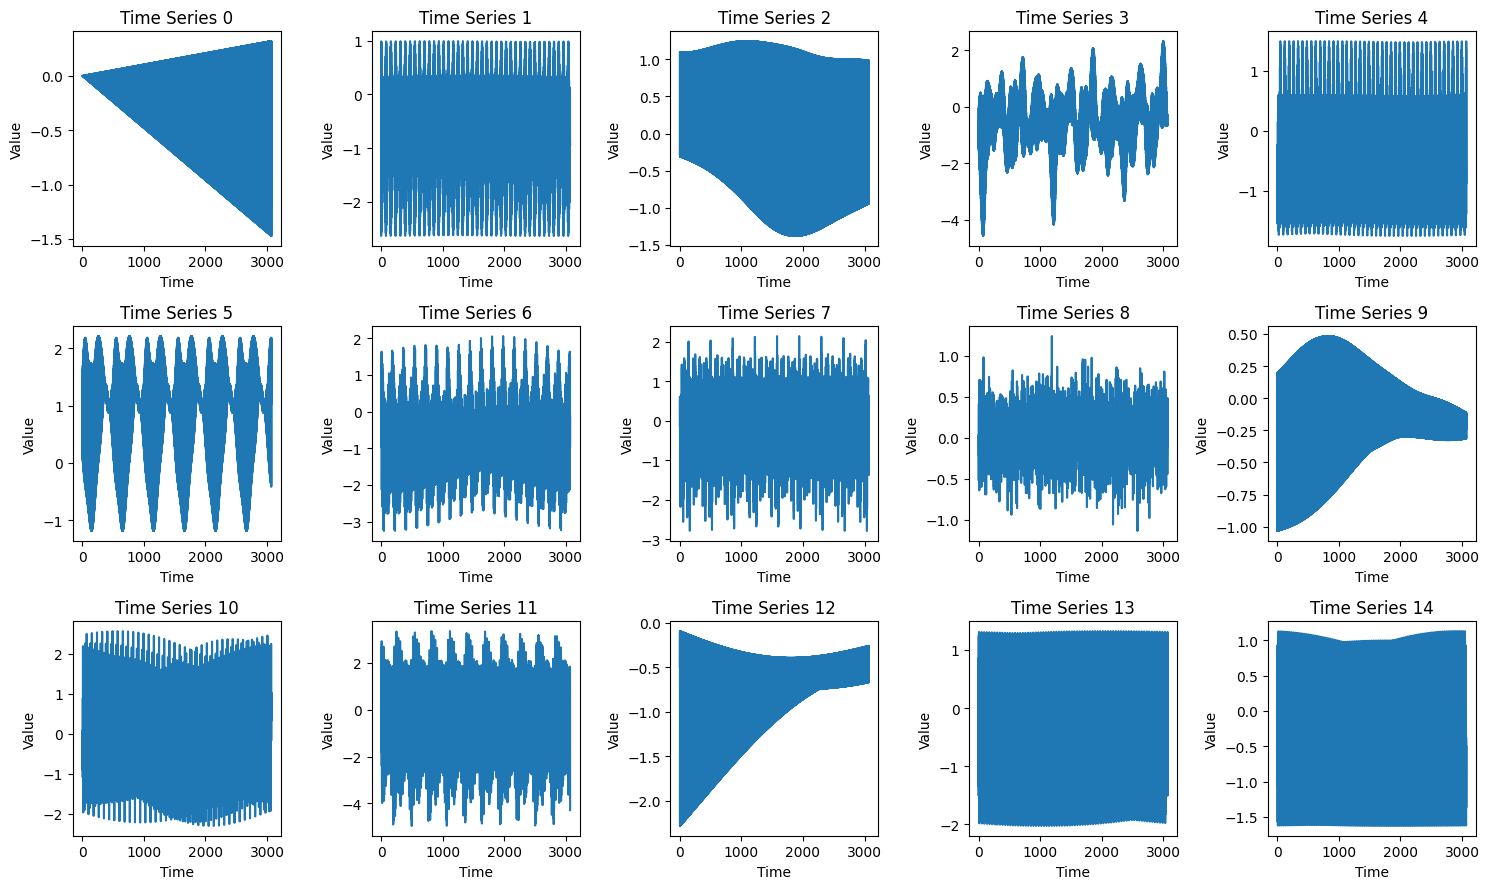

In [15]:
num_series = 15 ## plotting first 15 time series
plots_per_row = 5
num_rows = (num_series + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 3))

for i in range(num_series):
    row = i // plots_per_row
    col = i % plots_per_row
    ax = axes[row, col]
    ax.plot(df_ch['target'].iloc[i])
    ax.set_title(f'Time Series {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

## DYNOTEARS Causal Structure

DYNOTEARS is a linear causal structure learning framework. It learns the graph structure of a Dynamic Bayesian Network describing conditional dependencies between variables in data.

In [24]:
start_date = '2024-03-01 01:00:00' ## as it takes too long to load filtering data only for 1 month of data
electricity_prices_df_filt = electricity_prices_df[electricity_prices_df['Datetime (UTC)'] >= pd.to_datetime(start_date)]
print(electricity_prices_df_filt)

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
80329 2024-03-01 01:00:00    58.14    58.14    58.14    41.61    49.17   
80330 2024-03-01 02:00:00    57.83    57.83    57.83    42.03    13.00   
80331 2024-03-01 03:00:00    58.30    58.30    58.30    52.03    14.33   
80332 2024-03-01 04:00:00    62.49    62.49    62.49    52.52    48.04   
80333 2024-03-01 05:00:00    71.58    71.58    71.58    54.46    71.58   
...                   ...      ...      ...      ...      ...      ...   
81067 2024-03-31 19:00:00    66.17    47.01    68.37    70.00    50.09   
81068 2024-03-31 20:00:00    61.25    43.70    63.26    64.51    46.28   
81069 2024-03-31 21:00:00    44.99    50.29    51.29    54.90    43.98   
81070 2024-03-31 22:00:00    40.70    50.32    46.39    49.95    40.41   
81071 2024-03-31 23:00:00    32.10    44.39    42.60    48.98    40.39   

       Finland  France  Germany  Greece  ...  Netherlands  Norway  Poland  \
80329     0.00   58.14    58.14   

Creating a causal graph for the data according to the documentation provided.

In [25]:
df_str = electricity_prices_df_filt.drop(columns=['Datetime (UTC)'])
sm = from_pandas(df_str)

In [ ]:
### works on local but doesn't work on colab
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("supporting_files_dynotears/01_fully_connected.html")

<ipython-input-33-9b0ca94b3c35>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


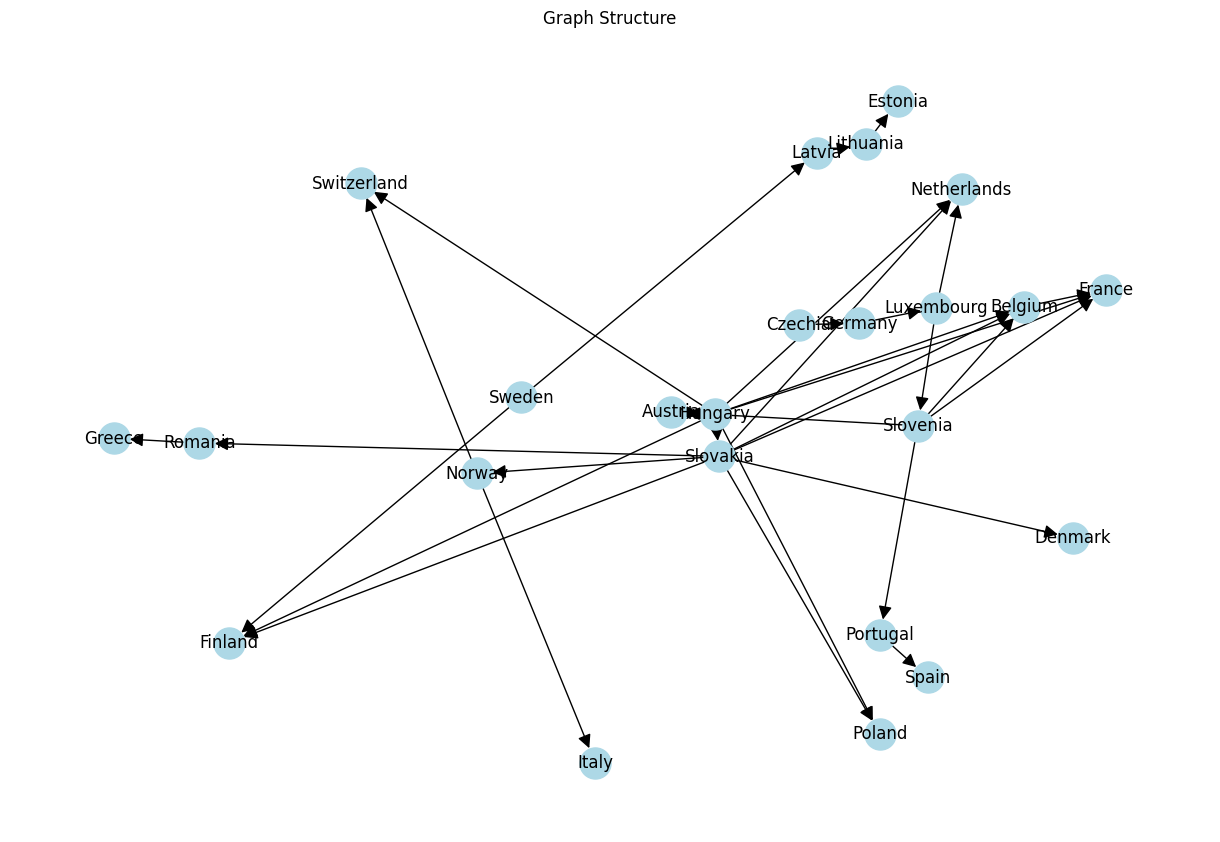

In [33]:
###colab version
G = nx.DiGraph(sm.edges)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=500, arrowsize=20, arrows=True)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Graph Structure")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
### prunning not important edges
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("supporting_files_dynotears/01_thresholded.html")

<ipython-input-35-1abe150c441e>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


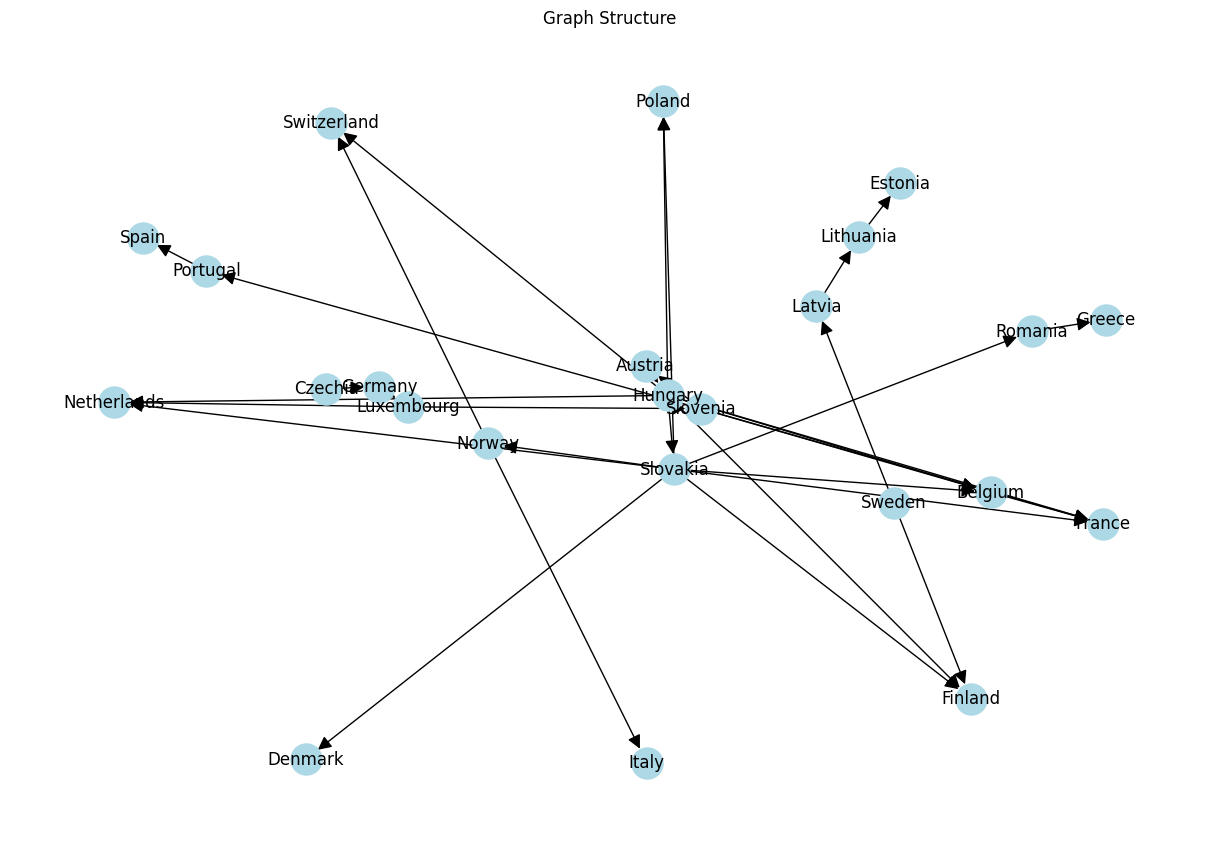

In [35]:
G = nx.DiGraph(sm.edges)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=500, arrowsize=20, arrows=True)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Graph Structure")
plt.axis('off')
plt.tight_layout()
plt.show()

In [47]:
print(f"Number of nodes: {sm.number_of_nodes()}")
print(f"Number of edges: {sm.number_of_edges()}")

Number of nodes: 24
Number of edges: 33


In [38]:
df_sm = pd.DataFrame(list(sm.edges(data=True)), columns=['From', 'To', 'Weight'])
print(df_sm)

          From           To                                             Weight
0      Austria      Hungary  {'origin': 'learned', 'weight': 0.885641122809...
1      Belgium       France  {'origin': 'learned', 'weight': 0.970562782435...
2      Czechia      Germany  {'origin': 'learned', 'weight': 0.897128751793...
3      Germany   Luxembourg  {'origin': 'learned', 'weight': 0.878354510156...
4      Hungary      Belgium  {'origin': 'learned', 'weight': 1.852959365638...
5      Hungary      Finland  {'origin': 'learned', 'weight': -1.84228518546...
6      Hungary       France  {'origin': 'learned', 'weight': 1.546880980879...
7      Hungary  Netherlands  {'origin': 'learned', 'weight': 0.983821913434...
8      Hungary       Poland  {'origin': 'learned', 'weight': -1.57739159290...
9      Hungary     Slovakia  {'origin': 'learned', 'weight': 0.896603730525...
10     Hungary  Switzerland  {'origin': 'learned', 'weight': -0.83071134160...
11      Latvia    Lithuania  {'origin': 'learned', '

In [39]:
for edge in sm.edges(data=True):
    print(f"From: {edge[0]}, To: {edge[1]}, Weight: {edge[2].get('weight', 'N/A')}")

From: Austria, To: Hungary, Weight: 0.8856411228094858
From: Belgium, To: France, Weight: 0.9705627824359152
From: Czechia, To: Germany, Weight: 0.8971287517934855
From: Germany, To: Luxembourg, Weight: 0.8783545101565464
From: Hungary, To: Belgium, Weight: 1.8529593656380159
From: Hungary, To: Finland, Weight: -1.8422851854657707
From: Hungary, To: France, Weight: 1.5468809808794557
From: Hungary, To: Netherlands, Weight: 0.9838219134341699
From: Hungary, To: Poland, Weight: -1.5773915929002502
From: Hungary, To: Slovakia, Weight: 0.8966037305253334
From: Hungary, To: Switzerland, Weight: -0.8307113416021032
From: Latvia, To: Lithuania, Weight: 0.901221215798987
From: Lithuania, To: Estonia, Weight: 0.8737223515664609
From: Luxembourg, To: Netherlands, Weight: 1.0040937687924292
From: Luxembourg, To: Slovenia, Weight: 0.8555285213236272
From: Norway, To: Italy, Weight: 0.8943824116671548
From: Norway, To: Switzerland, Weight: 0.839543507350952
From: Portugal, To: Spain, Weight: 1.0077

In [41]:
# adjacency matrix
adj_matrix = nx.to_numpy_array(sm)
print(adj_matrix)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.88564112  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.97056278  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.89712875  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        

In [42]:
# as a dataframe with labeled rows and columns
nodes = list(sm.nodes())
adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)
print(adj_df)

              Austria   Belgium  Czechia   Denmark   Estonia   Finland  \
Austria      0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Belgium      0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Czechia      0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Denmark      0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Estonia      0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Finland      0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
France       0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Germany      0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Greece       0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Hungary      0.000000  1.852959      0.0  0.000000  0.000000 -1.842285   
Italy        0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Latvia       0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Lithuania    0.000000  0.000000      0